# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 5: *CannyEdgeDetector*
Detect edges by the Canny multi-stage algorithm
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadL, createImageF, plotImageL, plotImageF 
from ConvolutionUtilities import createGaussianKernel, createSobelKernel, applyKernelF, applyKernelMA

# Math and iteration
from math import pi, cos, sin
from timeit import itertools

### Parameters:
    imageName = Input image name
    GaussianKernelSize = Gaussian kernel size. Filter noise
    sobelKernelSize = Sobel kernel size. Edge detection
    normalizeMagnitude = Normalize the convolution output
    upperT = upper threshold
    lowerT = lower threshold
    windowDelta = Size of window used in hysteresis

In [2]:
imageName = "Lizard.png"
GaussianKernelSize = 4
sobelKernelSize = 3
normalizeMagnitude = True
upperT = 0.25
lowerT = 0.1
windowDelta = 2

### Read and show image

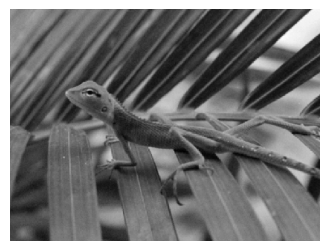

In [3]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter5/Input/")
inputImage, width, height = imageReadL(pathToDir + imageName)
plotImageL(inputImage, figureSize = 4)

### Apply Gaussian and Sobel Kernels

In [4]:
# Apply Gaussian kernel
gaussianKernel = createGaussianKernel(GaussianKernelSize)
gaussianImage = applyKernelF(inputImage, gaussianKernel)

# Apply Sobel kernel. We use normalized magnitude in this example
sobelX, sobelY = createSobelKernel(sobelKernelSize)
magnitude, angle, _, _ = applyKernelMA(gaussianImage, sobelX, sobelY, normalizeMagnitude)

# To store maximum suppression image
maxImage = createImageF(width, height)

# Non-maximum suppression
border = GaussianKernelSize
for x,y in itertools.product(range(border, width-border),                   \
                             range(border, height-border)):
    
    # Only potential edges can be maximum
    if magnitude[y,x] > lowerT:       
        # The normal angle is perpendicular to the edge angle
        normalAngle = angle[y,x] - pi / 2.0
        
        # Make sure the angle is between 0 and pi 
        while normalAngle < 0:   
            normalAngle += pi
        while normalAngle > pi:  
            normalAngle -= pi
        
        # Angle defining the first point
        baseAngle = int( 4 * normalAngle / pi ) * (pi / 4.0)
        
        # Integer delta positions for interpolation
        # We use -y since the image origin is in top corner
        x1, y1 = int(round(cos(baseAngle))), -int(round(sin(baseAngle)))
        x2, y2 = int(round(cos(baseAngle + pi / 4.0))),                     \
                -int(round(sin(baseAngle + pi / 4.0)))
        
        # How far we are from (x1,y1). 
        # Maximum difference is pi / 4.0, so we multiply by 2
        w = cos(2.0*(normalAngle - baseAngle))
        
        # Point to interpolate
        M1 = w * magnitude[y+y1,x+x1] + (1.0 - w) * magnitude[y+y2,x+x2]
        
        # Point to interpolate for pixels in the other side of the edge
        M2 = w * magnitude[y-y1,x-x1] + (1.0 - w) * magnitude[y-y2,x-x2]
         
        # Determine if it is a maximum. If so make sure it will be preserved 
        if magnitude[y,x] > M1 and magnitude[y,x] > M2:
            maxImage[y,x] = magnitude[y,x]

### Show result

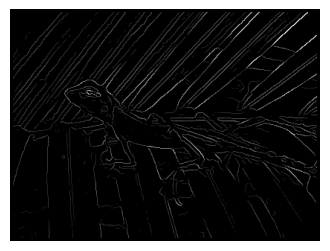

In [5]:
plotImageF(maxImage, figureSize = 4)

### Compute hysteresis thresholded images

In [6]:
# To compute hysteresis thresholded images we require two thresholds
edges = createImageF(width, height)
potentialEdges = [ ]

# Divide pixels as edges, no edges and unassigned 
for x,y in itertools.product(range(1, width-1), range(1, height-1)):
    # These are edges
    if maxImage[y,x] > upperT:   edges[y,x] = 255
    # These are pixels that we do not want as edges   
    if maxImage[y,x] < lowerT:   edges[y,x] = 0
    # These may be edges    
    if maxImage[y,x] > lowerT and maxImage[y,x] <= upperT:
        edges[y,x] = 128

## Show double threshold image

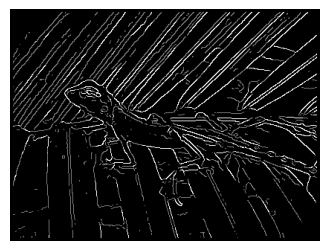

In [7]:
plotImageF(edges, figureSize = 4)

### Resolve the potential edges

In [8]:
for x,y in itertools.product(range(1, width-1), range(1, height-1)):
    # For each edge
    if edges[y,x] == 255:
        
        # Examine neighbors
        potentialEdges = [ ]
        for wx,wy in itertools.product(range(-windowDelta, windowDelta+1),      \
                                       range(-windowDelta, windowDelta+1)):              
            # It becomes an edge
            if edges[y+wy,x+wx] == 128:
                edges[y+wy,x+wx] = 255
                potentialEdges.append((y+wy,x+wx))
        
        # Look into new edges
        while len(potentialEdges) > 0:
            # Take element from potential edges
            y, x = (potentialEdges[0])[0],  (potentialEdges[0])[1]
            potentialEdges = potentialEdges[1:]
            
            # Examine neighbor
            for wx,wy in itertools.product(range(-windowDelta, windowDelta+1),    \
                                           range(-windowDelta, windowDelta+1)):   
                    # It becomes an edge
                    if edges[y+wy,x+wx] == 128:
                        edges[y+wy,x+wx] = 255
                        potentialEdges.append((y+wy,x+wx))
        
# Clean up remaining potential edges                            
for x,y in itertools.product(range(1, width-1), range(1, height-1)):
    if edges[y,x] == 128:   
        edges[y,x] = 0

### Show final edges

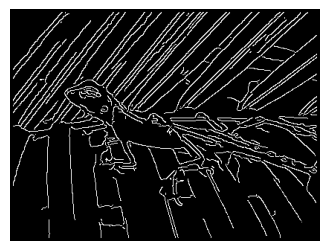

In [9]:
plotImageF(edges, figureSize = 4)